In [1]:
from configs import project_config
import matplotlib.pyplot as plt
import numpy as np
import scipy
import torch
from tqdm import tqdm
from src.generative_modelling.models.ClassVPSDEDiffusion import VPSDEDiffusion
import os

In [99]:
from configs.RecursiveVPSDE.recursive_PostMeanScore_fOU_T256_H05_tl_5data import get_config as get_config_postmean
config_postmean = get_config_postmean()

rng = np.random.default_rng()
drift_eval_diff_time = int(config_postmean.max_diff_steps - 9000)
device = "cpu"

revDiff_time_scale = torch.linspace(start=config_postmean.end_diff_time, end=config_postmean.sample_eps,
                                 steps=config_postmean.max_diff_steps).to(device)
real_time_scale = torch.linspace(start=1 / config_postmean.ts_length, end=1, steps=config_postmean.ts_length).to(device)

max_diff_steps = config_postmean.max_diff_steps
sample_eps = config_postmean.sample_eps
mean_rev = config_postmean.mean_rev
ts_step = 1 / config_postmean.ts_length
eval_ts_length = 256

In [55]:
from scipy.stats import wasserstein_distance
import ot
def bootstrap_test_wasserstein(sample1, sample2, num_bootstrap=200):
    # Step 1: Compute the observed Wasserstein distance
    M = ot.dist(sample1, sample2, metric='euclidean')
    a = np.ones((sample1.shape[0],)) / sample1.shape[0]  # Uniform weights for X
    b = np.ones((sample1.shape[0],)) / sample1.shape[0]  # Uniform weights for Y

    #observed_distance = wasserstein_distance(sample1, sample2)
    observed_distance = ot.lp.emd2(a, b, M = M)
    # Step 2: Bootstrap samples
    bootstrap_distances = []
    combined = np.vstack([sample1, sample2])
    for _ in range(num_bootstrap):
        np.random.shuffle(combined)
        obs_perm = combined[:sample1.shape[0], :]
        sim_perm = combined[sample2.shape[0]:, :]

        # Step 3: Compute Wasserstein distance for bootstrap samples
        M = ot.dist(obs_perm, sim_perm, metric='euclidean')
        boot_distance = (ot.lp.emd2(a, b, M = M))
        #boot_distance = wasserstein_distance(boot_sample1, boot_sample2)
        bootstrap_distances.append(boot_distance)

    # Step 4: Calculate p-value and confidence intervals
    bootstrap_distances = np.array(bootstrap_distances)
    #print(bootstrap_distances, observed_distance)
    p_value = np.mean(bootstrap_distances >= observed_distance)


    return observed_distance, p_value

In [82]:
rootpath = project_config.ROOT_DIR + f"experiments/results/"
files = os.listdir(rootpath)
keepfiles = []
for file in files:
    if "rec" in file and "NEp" in file and "fOUv" not in file and "fOUm" not in file and "fSin" not in file and "v0" not in file and "m0" not in file and "fBm" not in file and "H7" not in file and "markv" not in file:
        keepfiles.append(rootpath + file)
print(len(keepfiles))

112


In [116]:
rootpath = project_config.ROOT_DIR + f"experiments/results/"
files = os.listdir(rootpath)
for file in files:
    if "rec_TSM_False_incs_True_unitIntv_fOU_VPSDE_model_H5000e-01_T256_Ndiff10000_Tdiff1000e+00_trainEps1e-04_BetaMax20000e+01_BetaMin10000e-04_DiffEmbSize64_ResLay10_ResChan8_DiffHiddenSize64_TrueHybrid_TrueWghts_LSTM_H20_Nlay1_fOU00_tl5_NEp" in file:
        print(file)
        print("\n")

rec_TSM_False_incs_True_unitIntv_fOU_VPSDE_model_H5000e-01_T256_Ndiff10000_Tdiff1000e+00_trainEps1e-04_BetaMax20000e+01_BetaMin10000e-04_DiffEmbSize64_ResLay10_ResChan8_DiffHiddenSize64_TrueHybrid_TrueWghts_LSTM_H20_Nlay1_fOU00_tl5_NEp2920.csv.gzip


rec_TSM_False_incs_True_unitIntv_fOU_VPSDE_model_H5000e-01_T256_Ndiff10000_Tdiff1000e+00_trainEps1e-04_BetaMax20000e+01_BetaMin10000e-04_DiffEmbSize64_ResLay10_ResChan8_DiffHiddenSize64_TrueHybrid_TrueWghts_LSTM_H20_Nlay1_fOU00_tl5_NEp1920.csv.gzip


rec_TSM_False_incs_True_unitIntv_fOU_VPSDE_model_H5000e-01_T256_Ndiff10000_Tdiff1000e+00_trainEps1e-04_BetaMax20000e+01_BetaMin10000e-04_DiffEmbSize64_ResLay10_ResChan8_DiffHiddenSize64_TrueHybrid_TrueWghts_LSTM_H20_Nlay1_fOU00_tl5_NEp1440.csv.gzip


rec_TSM_False_incs_True_unitIntv_fOU_VPSDE_model_H5000e-01_T256_Ndiff10000_Tdiff1000e+00_trainEps1e-04_BetaMax20000e+01_BetaMin10000e-04_DiffEmbSize64_ResLay10_ResChan8_DiffHiddenSize64_TrueHybrid_TrueWghts_LSTM_H20_Nlay1_fOU00_tl5_NEp480.csv.gzip

In [83]:
# Plot the drift estimator for different sample paths across time
import pandas as pd
import gzip
pvals = []
for file in keepfiles:
    try:
        gen_paths = pd.read_csv(file, compression="gzip", index_col=[0,1]).to_numpy().cumsum(axis=1)
        gen_paths = gen_paths[np.random.choice(np.arange(gen_paths.shape[0]), 1000, replace=False),:]
        synthetic_paths = np.load(config_postmean.data_path)[np.random.choice(np.arange(config_postmean.dataSize), gen_paths.shape[0], replace=False),:]
        pval = (bootstrap_test_wasserstein(gen_paths, synthetic_paths)[1])
        pvals.append(pval)
    except gzip.BadGzipFile:
        try:
            gen_paths = pd.read_csv(file, index_col=[0,1]).to_numpy().cumsum(axis=1)
            gen_paths = gen_paths[np.random.choice(np.arange(gen_paths.shape[0]), 1000, replace=False),:]
            synthetic_paths = np.load(config_postmean.data_path)[np.random.choice(np.arange(config_postmean.dataSize), gen_paths.shape[0], replace=False),:]
            pval = (bootstrap_test_wasserstein(gen_paths, synthetic_paths)[1])
            pvals.append(pval)
        except (pd.errors.ParserError,UnicodeDecodeError) :
            os.remove(file)

In [98]:
pvals

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.09,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.195,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.7,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.46,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.12,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [92]:
args =list((np.argwhere(np.array(pvals) !=0.)).flatten())

In [106]:
validpath_files = []
for idx in args:
    validpath_files.append(keepfiles[idx])
    print(validpath_files[-1])
    print("\n")
# rec_TSM_False_incs_True_unitIntv_fOU_VPSDE_model_H5000e-01_T256_Ndiff10000_Tdiff1000e+00_trainEps1e-04_BetaMax20000e+01_BetaMin10000e-04_DiffEmbSize64_ResLay10_ResChan8_DiffHiddenSize64_TrueHybrid_TrueWghts_LSTM_H20_Nlay1_fOU00_tl5_Nep*
# has the most paths which agree with synthetic data but only 301, 1440, 920, 6920 (but not 480 or 960 or 2920, and we dont have 12920)

/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/rec_PM_TSM_False_incs_True_unitIntv_fOU_VPSDE_model_H5000e-01_T256_Ndiff10000_Tdiff1000e+00_trainEps1e-04_BetaMax20000e+01_BetaMin10000e-04_DiffEmbSize64_ResLay10_ResChan8_DiffHiddenSize64_TrueHybrid_TrueWghts_LSTM_H20_Nlay1_fOU00_tl5_erNEp12920.csv.gzip


/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/rec_TSM_False_incs_True_unitIntv_fOU_VPSDE_model_H5000e-01_T256_Ndiff10000_Tdiff1000e+00_trainEps1e-04_BetaMax20000e+01_BetaMin10000e-04_DiffEmbSize64_ResLay10_ResChan8_DiffHiddenSize64_TrueHybrid_TrueWghts_LSTM_H20_Nlay1_fOU00_tl5_NEp1920.csv.gzip


/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/rec_TSM_False_incs_True_unitIntv_fOU_VPSDE_model_H5000e-01_T256_Ndiff10000_Tdiff1000e+00_trainEps1e-04_BetaMax20000e+01_BetaMin10000e-04_DiffEmbSize64_ResLay10_ResChan8_DiffHiddenSize64_TrueHybrid_TrueWghts_LSTM_H20_Nlay1_fOU00_tl5_NEp1440.csv.gzip


/Users/marcos/GitHubRepos/Fr

/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/rec_PM_TSM_False_incs_True_unitIntv_fOU_VPSDE_model_H5000e-01_T256_Ndiff10000_Tdiff1000e+00_trainEps1e-04_BetaMax20000e+01_BetaMin10000e-04_DiffEmbSize64_ResLay10_ResChan8_DiffHiddenSize64_TrueHybrid_TrueWghts_LSTM_H20_Nlay1_fOU00_tl5_erNEp12920.csv.gzip


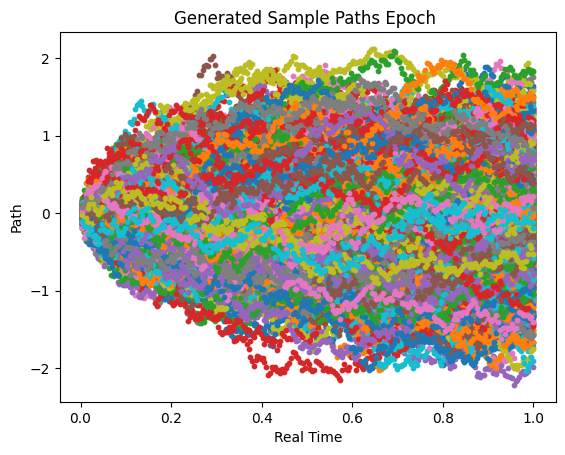

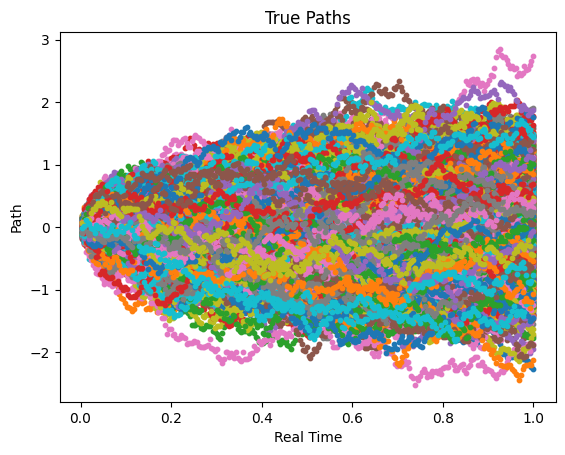

/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/rec_TSM_False_incs_True_unitIntv_fOU_VPSDE_model_H5000e-01_T256_Ndiff10000_Tdiff1000e+00_trainEps1e-04_BetaMax20000e+01_BetaMin10000e-04_DiffEmbSize64_ResLay10_ResChan8_DiffHiddenSize64_TrueHybrid_TrueWghts_LSTM_H20_Nlay1_fOU00_tl5_NEp1920.csv.gzip


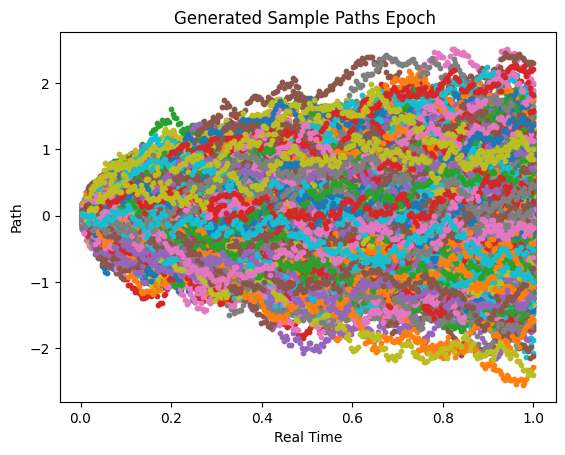

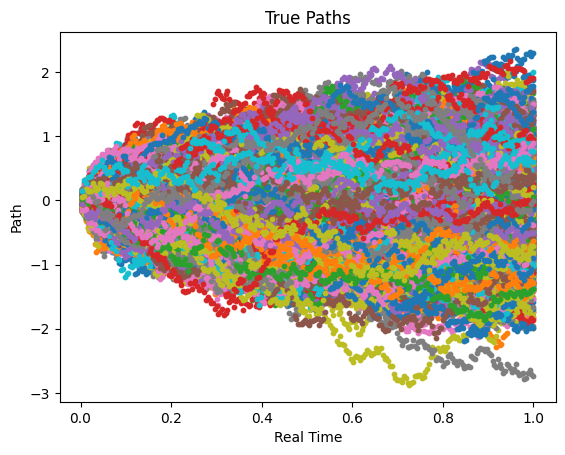

/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/rec_TSM_False_incs_True_unitIntv_fOU_VPSDE_model_H5000e-01_T256_Ndiff10000_Tdiff1000e+00_trainEps1e-04_BetaMax20000e+01_BetaMin10000e-04_DiffEmbSize64_ResLay10_ResChan8_DiffHiddenSize64_TrueHybrid_TrueWghts_LSTM_H20_Nlay1_fOU00_tl5_NEp1440.csv.gzip


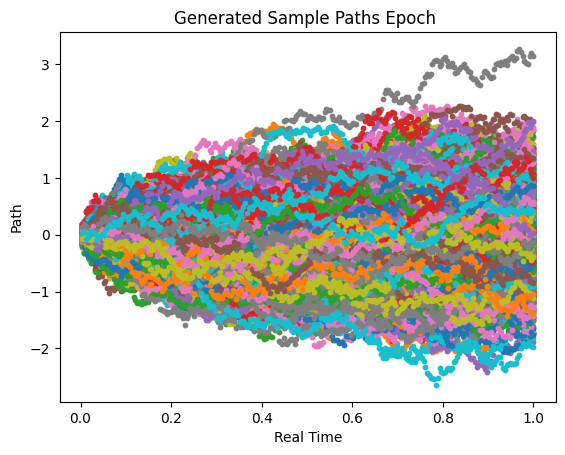

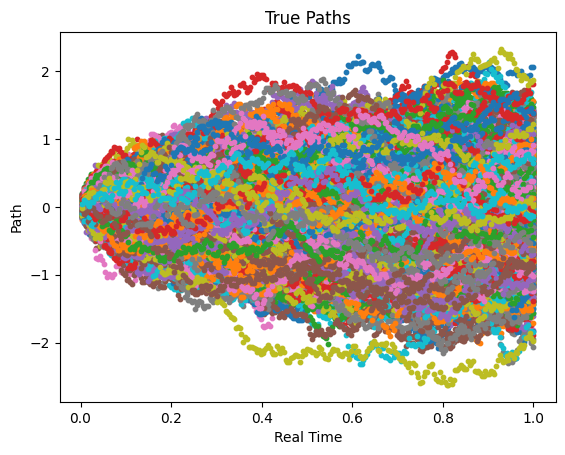

/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/rec_TSM_False_incs_True_unitIntv_fOU_VPSDE_model_H5000e-01_T256_Ndiff10000_Tdiff1000e+00_trainEps1e-04_BetaMax20000e+01_BetaMin10000e-04_DiffEmbSize64_ResLay10_ResChan8_DiffHiddenSize64_TrueHybrid_TrueWghts_LSTM_H20_Nlay1_fOU00_tl5_NEp6920.csv.gzip


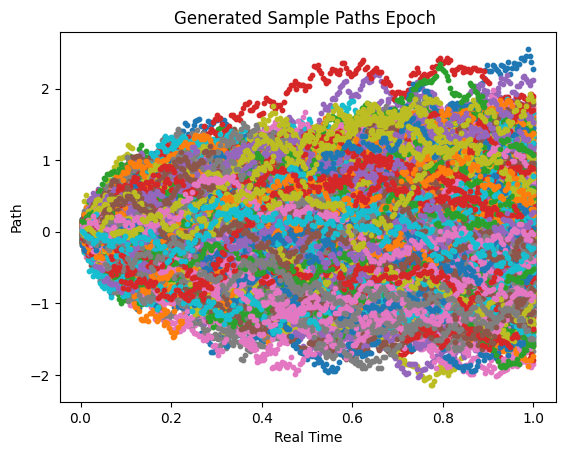

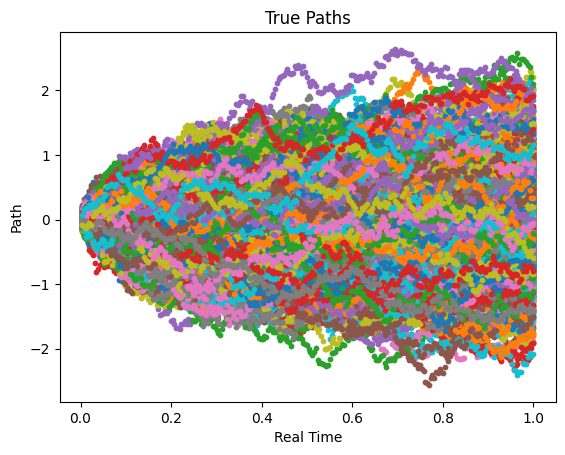

/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/rec_TSM_False_incs_True_unitIntv_fOU_VPSDE_model_H5000e-01_T256_Ndiff10000_Tdiff1000e+00_trainEps1e-04_BetaMax20000e+01_BetaMin10000e-04_DiffEmbSize64_ResLay10_ResChan8_DiffHiddenSize64_TrueHybrid_TrueWghts_LSTM_H20_Nlay1_fOU00_tl5_NEp301.csv.gzip


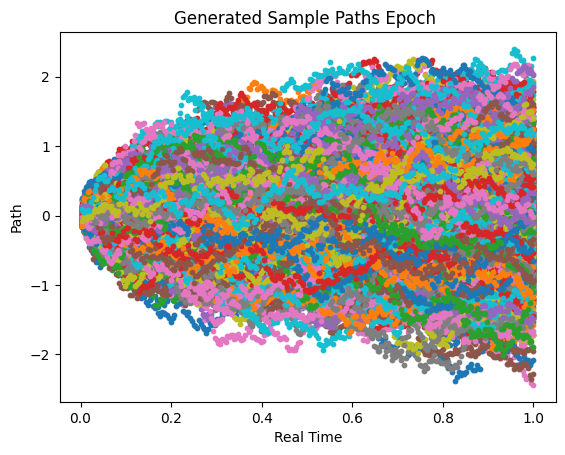

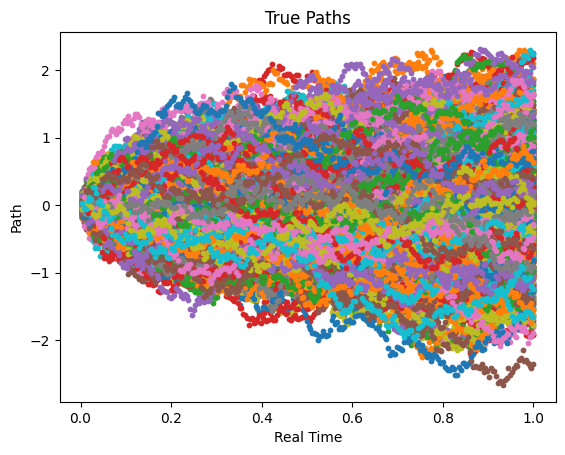

In [100]:
for idx in args:
    file = keepfiles[idx]
    print(file)
    num_simulated_paths = 1000
    gen_paths = pd.read_csv(file, compression="gzip", index_col=[0,1]).to_numpy().cumsum(axis=1)
    gen_paths = gen_paths[np.random.choice(np.arange(gen_paths.shape[0]), num_simulated_paths, replace=False),:]
    synthetic_paths = np.load(config_postmean.data_path)[np.random.choice(np.arange(config_postmean.dataSize), gen_paths.shape[0], replace=False),:]
    for pathid in range(num_simulated_paths):
        plt.scatter(real_time_scale[:eval_ts_length].cpu(), gen_paths[pathid,:], s=10)
    plt.xlabel("Real Time")
    plt.ylabel("Path")
    plt.title(f"Generated Sample Paths Epoch ")
    plt.show()
    plt.close()
    for pathid in range(num_simulated_paths):
        plt.scatter(real_time_scale[:eval_ts_length].cpu(), synthetic_paths[pathid,:], s=10)
    plt.xlabel("Real Time")
    plt.ylabel("Path")
    plt.title(f"True Paths")
    plt.show()
    plt.close()

In [109]:
# Plot the drift estimator for different sample paths across time
import pandas as pd
for idx in args:
    file = keepfiles[idx]
    gen_paths = pd.read_csv(file, compression="gzip", index_col=[0,1]).to_numpy().cumsum(axis=1)
    gen_paths = gen_paths[np.random.choice(np.arange(gen_paths.shape[0]), 1000, replace=False),:]
    synthetic_paths = np.load(config_postmean.data_path)[np.random.choice(np.arange(config_postmean.dataSize), gen_paths.shape[0], replace=False),:]
    pval = (bootstrap_test_wasserstein(gen_paths, synthetic_paths, num_bootstrap=1000)[1])
    print(pval, pvals[idx])

0.422 0.09
0.547 0.195
0.86 0.7
0.827 0.46
0.022 0.12


In [113]:
from configs.RecursiveVPSDE.recursive_fOU_T256_H05_tl_5data import get_config
config = get_config()
print(config.experiment_path)
for file in validpath_files:
    print(config.experiment_path in file)

/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/rec_TSM_False_incs_True_unitIntv_fOU_VPSDE_model_H5000e-01_T256_Ndiff10000_Tdiff1000e+00_trainEps1e-04_BetaMax20000e+01_BetaMin10000e-04_DiffEmbSize64_ResLay10_ResChan8_DiffHiddenSize64_TrueHybrid_TrueWghts_LSTM_H20_Nlay1_fOU00_tl5
False
True
True
True
True
